# Diabetes Risk Indicator Project
## Part 2
CSPB 3022 Summer 2023 <br>
Thomas Chavez

## Project Topic 
Diabetes is one the most common chronic diseases in the US, impacting many Americans and burdening the economy. Diabetes describes when the body's ability to regulate blood glucose levels becomes impaired. The prevalence of Type 2 diabetes is dependent on a variety of factors, with some factors posing higher risks. It is important for healthcare professionals to recognize the warning signs in patients that could lead to this disease in advance.

<br>
This project will focus on developing a model for **predicting** whether someone is at high-risk for diabetes based on a plethora of health indicators such as "high blood pressure" and "high cholesterol". More specifically, this is a **classification** task where the goal will be to develop a function that takes an input of 21 attributes and predict whether that individual has diabetes or prediabetes. These attributes include both categoric and numeric types. 
 
 
<br>
**Goals**

<br>
For training data I plan to:

* Predict diabetes classification for test cases not processed in developing the model.
* Determine most critical factors for prediction
* Assess accuracy of predictions

In [1]:
%matplotlib inline
import numpy as np
import scipy as sp
import scipy.stats as stats
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import patsy
import sklearn
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn import preprocessing 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import chi2 
from sklearn import linear_model
from sklearn import metrics 
from sklearn.model_selection import GridSearchCV
import sklearn.neighbors as neighbors
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report
from sklearn import tree
from sklearn import svm
from sklearn.feature_selection import RFE
from sklearn.model_selection import cross_val_predict
import statsmodels.formula.api as smf
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from  warnings import simplefilter
from sklearn.exceptions import ConvergenceWarning

## Data Source and Description
This project utilizes the dataset downloaded from Kaggle located at https://www.kaggle.com/code/alexteboul/diabetes-health-indicators-dataset-notebook. This dataset was extracted from the Behavioral Risk Factor Surveillance System (BRSS) survey which is conducted annually by the CDC.

<br>
APA Citation: <br>
Teboul, A. (2021, November 8). Diabetes health indicators dataset. Kaggle.                          https://www.kaggle.com/datasets/alexteboul/diabetes-health-indicators-dataset 


<br>
This dataset contains 70,692 survey responses which include 21 health indicator predictors and 1 output variable (Diabetes Status). The output variable is given for every survey response. No personal information is associated with any survey response.
<br>


In [2]:
# load in the dataset from Kaggle/CDC
# https://www.kaggle.com/code/alexteboul/diabetes-health-indicators-dataset-notebook
#cdc_df = pd.read_csv('diabetes_data.csv', na_values=['?'], low_memory=False)
cdc_df = pd.read_csv('diabetes_data.csv', low_memory=False)

In [3]:
# A preview of the data is shown below. The number of attributes total 22.
cdc_df.head()
#shape = cdc_df.shape
#print(shape)

,Diabetes_binary,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,...,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income
0,0.0,1.0,0.0,1.0,26.0,0.0,0.0,0.0,1.0,0.0,...,1.0,0.0,3.0,5.0,30.0,0.0,1.0,4.0,6.0,8.0
1,0.0,1.0,1.0,1.0,26.0,1.0,1.0,0.0,0.0,1.0,...,1.0,0.0,3.0,0.0,0.0,0.0,1.0,12.0,6.0,8.0
2,0.0,0.0,0.0,1.0,26.0,0.0,0.0,0.0,1.0,1.0,...,1.0,0.0,1.0,0.0,10.0,0.0,1.0,13.0,6.0,8.0
3,0.0,1.0,1.0,1.0,28.0,1.0,0.0,0.0,1.0,1.0,...,1.0,0.0,3.0,0.0,3.0,0.0,1.0,11.0,6.0,8.0
4,0.0,0.0,0.0,1.0,29.0,1.0,0.0,0.0,1.0,1.0,...,1.0,0.0,2.0,0.0,0.0,0.0,0.0,8.0,5.0,8.0


Clearly, from the data below and above, all of the attributes by default have been assigned float types which is incorrect. Most are categorical and will need to be changed to the appropriate type in the following steps.

In [4]:
# General information and datatypes of each attribute. These datatypes are not yet updated
cdc_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70692 entries, 0 to 70691
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Diabetes_binary       70692 non-null  float64
 1   HighBP                70692 non-null  float64
 2   HighChol              70692 non-null  float64
 3   CholCheck             70692 non-null  float64
 4   BMI                   70692 non-null  float64
 5   Smoker                70692 non-null  float64
 6   Stroke                70692 non-null  float64
 7   HeartDiseaseorAttack  70692 non-null  float64
 8   PhysActivity          70692 non-null  float64
 9   Fruits                70692 non-null  float64
 10  Veggies               70692 non-null  float64
 11  HvyAlcoholConsump     70692 non-null  float64
 12  AnyHealthcare         70692 non-null  float64
 13  NoDocbcCost           70692 non-null  float64
 14  GenHlth               70692 non-null  float64
 15  MentHlth           

## Factors
The dataset contains either discrete numerical or categorical. No values were observed to be missing. The total number of data objects is 70,692 with 21 predictors. The data types will be updated in the data cleaning section. Below is a summary of each attribute:
* Diabetes_binary: Categorical with 3 unique values
* HighBP: Categorical with 2 unique values
* HighChol: Categorical with 2 unique values
* CholCheck: Categorical with 2 unique values
* BMI: Discrete numerical
* Smoker: Categorical with 2 unique values
* Stroke: Categorical with 2 unique values
* HeartDiseaseorAttack: Categorical with 2 unique values
* PhysActivity: Categorical with 2 unique values
* Fruits: Categorical with 2 unique values
* Veggies: Categorical with 2 unique values
* HvyAlcoholConsump: Categorical with 2 unique values
* AnyHealthcare: Categorical with 2 unique values
* NoDocbcCost: Categorical with 2 unique values
* GenHlth: Discrete numerical
* PhysHlth: Discrete numerical
* DiffWalk: Categorical with 2 unique values
* Sex: Categorical with 2 unique values
* Age: Categorical with 13 unique values
* Education: Categorical with 6 unique values
* Income: Categorical with 8 unique values

## Real World Application
I will also be examining whether there is a connection between mental health and risk for diabetes. This is not yet investigated at large scale and could open up some additional questions on how and why mental health can impact physical health. 

# Data Cleaning and Exploratory Data Analysis 


## Changing Data Types

The following code block uses the .astype() function to change the majority of the binary attributes from float to categorical types. The exceptions are the BMI, MentHlth, and PhysHlth attributes which were changed to integer types as they are distributed on a discrete scale.

In [5]:
#Because pandas assumed all float datatypes, I change the types of each to the appropriate type
cdc_df['Diabetes_binary'] = cdc_df['Diabetes_binary'].astype('category')
cdc_df['HighBP'] = cdc_df['HighBP'].astype('category')
cdc_df['HighChol'] = cdc_df['HighChol'].astype('category')
cdc_df['CholCheck'] = cdc_df['CholCheck'].astype('category')
cdc_df['BMI'] = cdc_df['BMI'].astype('int')
cdc_df['Smoker'] = cdc_df['Smoker'].astype('category')
cdc_df['Stroke'] = cdc_df['Stroke'].astype('category')
cdc_df['HeartDiseaseorAttack'] = cdc_df['HeartDiseaseorAttack'].astype('category')
cdc_df['PhysActivity'] = cdc_df['PhysActivity'].astype('category')
cdc_df['Fruits'] = cdc_df['Fruits'].astype('category')
cdc_df['Veggies'] = cdc_df['Veggies'].astype('category')
cdc_df['HvyAlcoholConsump'] = cdc_df['HvyAlcoholConsump'].astype('category')
cdc_df['AnyHealthcare'] = cdc_df['AnyHealthcare'].astype('category')
cdc_df['NoDocbcCost'] = cdc_df['NoDocbcCost'].astype('category')
cdc_df['GenHlth'] = cdc_df['GenHlth'].astype('category')
cdc_df['MentHlth'] = cdc_df['MentHlth'].astype('int')
cdc_df['PhysHlth'] = cdc_df['PhysHlth'].astype('int')
cdc_df['DiffWalk'] = cdc_df['DiffWalk'].astype('category')
cdc_df['Sex'] = cdc_df['Sex'].astype('category')
cdc_df['Age'] = cdc_df['Age'].astype('category')
cdc_df['Education'] = cdc_df['Education'].astype('category')
cdc_df['Income'] = cdc_df['Income'].astype('category')

## Basic Statistics of the Data

The following code block confirms that all the types of the attributes were changed properly and further analysis can be done without error.

In [6]:
# Basic info of data after changing data types
cdc_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70692 entries, 0 to 70691
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype   
---  ------                --------------  -----   
 0   Diabetes_binary       70692 non-null  category
 1   HighBP                70692 non-null  category
 2   HighChol              70692 non-null  category
 3   CholCheck             70692 non-null  category
 4   BMI                   70692 non-null  int64   
 5   Smoker                70692 non-null  category
 6   Stroke                70692 non-null  category
 7   HeartDiseaseorAttack  70692 non-null  category
 8   PhysActivity          70692 non-null  category
 9   Fruits                70692 non-null  category
 10  Veggies               70692 non-null  category
 11  HvyAlcoholConsump     70692 non-null  category
 12  AnyHealthcare         70692 non-null  category
 13  NoDocbcCost           70692 non-null  category
 14  GenHlth               70692 non-null  category
 15  Me

The following table describes the breakdown of the non-categorical attributes. As shown for MentHlth and PhysHlth, the distributions are skewed heavily toward the value of 0 which indicates that in the last 30 days, the majority of people have not had issues with either their mental or physical health. However, because the majority of people do not diabetes/prediabetes in this dataset, it does not tell us anything unusual yet.

In [7]:
# Basic descriptions of numerical data after changing data types:
cdc_df.describe()

,BMI,MentHlth,PhysHlth
count,70692.000000,70692.000000,70692.000000
mean,29.856985,3.752037,5.810417
std,7.113954,8.155627,10.062261
min,12.000000,0.000000,0.000000
25%,25.000000,0.000000,0.000000
50%,29.000000,0.000000,0.000000
75%,33.000000,2.000000,6.000000
max,98.000000,30.000000,30.000000


## Preliminary Data Cleaning
Here, upon initially working with the data, I realize I want to generalize the model to treat Prediabetes and Diabetes as the same. Therefore, I will transform the "Diabetes_012" attribute to only have two categorical values where 0 indicates no diabetes and 1 indicates Prediabetes or Diabetes.

In [8]:
cdc_df['Diabetes_binary'] = cdc_df['Diabetes_binary'].replace(2, 1)
cdc_df = cdc_df.rename(columns={'Diabetes_binary': 'Diabetes'})

I am also planning to delete the column, 'CholCheck', with is an attribute that descibes if an individual has checked their cholesterol in the last 5 years. The significant majority have checked and this is not as seemingly important of a health indicator as the attribute 'HighChol' which indicates that for those who have checked if they have high cholesterol or not.

In [9]:
cdc_df = cdc_df.drop('CholCheck', axis=1)

## Preliminary Data Visualization
I will create some basic histograms of some of the attributes to learn more about the spread of certain health indicators. The following code block creates a function that can be easily applied to any attribute to create a histogram to gain rough insight into the distribution of data.

In [10]:
#Histogram plotting function:
def histo(cat, df):
    sns.histplot(df[cat], color='blue')
    plt.title(cat, fontsize=17)
    plt.ylabel('Occurrence', fontsize=15)
    plt.show();

As intended by the Kaggle website, the class designations are identical and no adjustments will need to be made during sampling.

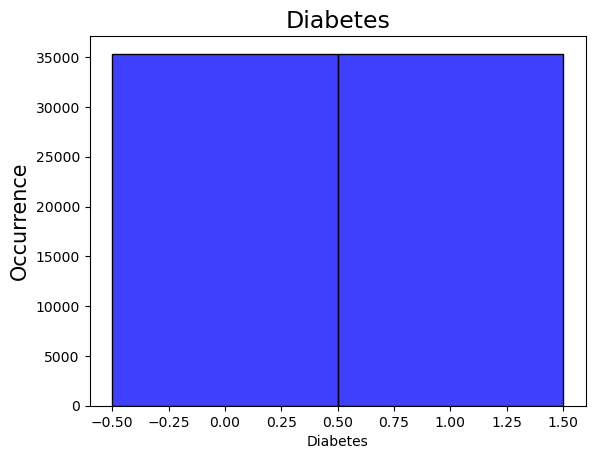

In [11]:
histo('Diabetes', cdc_df)

The GenHlth category indicates 1=Excellent and 5=poor.

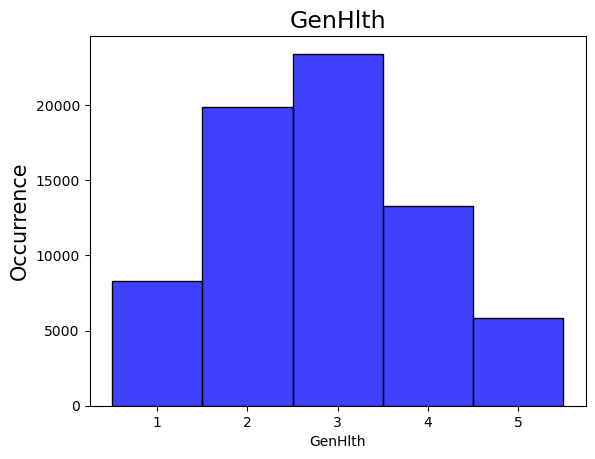

In [12]:
histo('GenHlth', cdc_df)

For Age, these are categories where 1=18-24, 9=60-64, and 13=80 or older. 

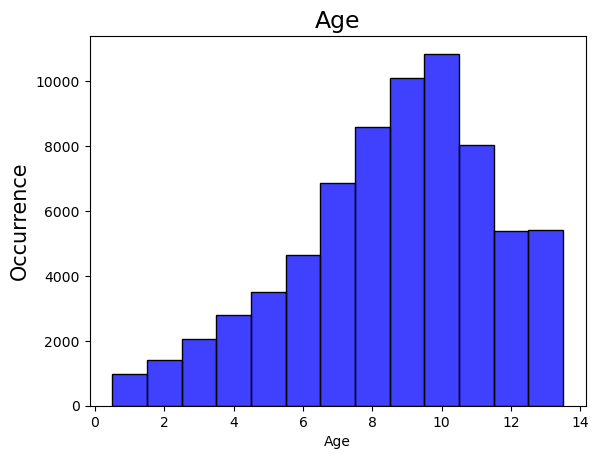

In [13]:
histo('Age', cdc_df)

For Sex, 0=female and 1=male

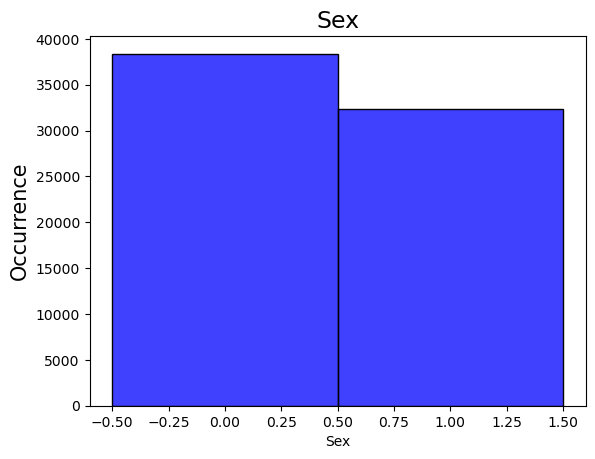

In [14]:
histo('Sex', cdc_df)

BMI indicates Body Mass Index.

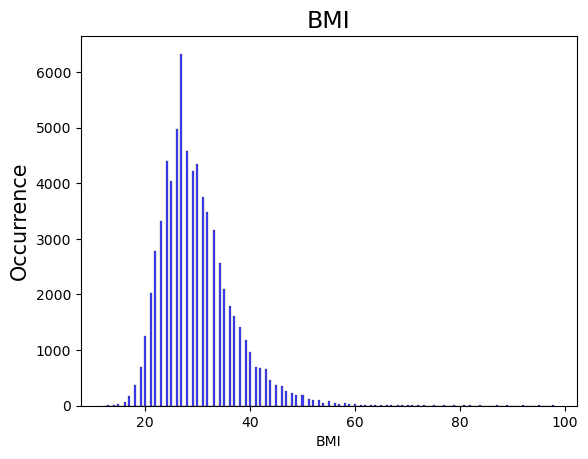

In [15]:
histo('BMI', cdc_df)

## Numeric Attributes
For each numeric factor, I will use box-plots, scatter plots, and KDE plots to visualize the distributions

In [16]:
n_cols = ['BMI', 'PhysHlth', 'MentHlth']

In [17]:
# boxplot plotting function 
def boxplot(factor, df):
    sns.boxplot(x = cdc_df[factor], width = 0.4);
    plt.title(factor, fontsize=15)
    plt.show();

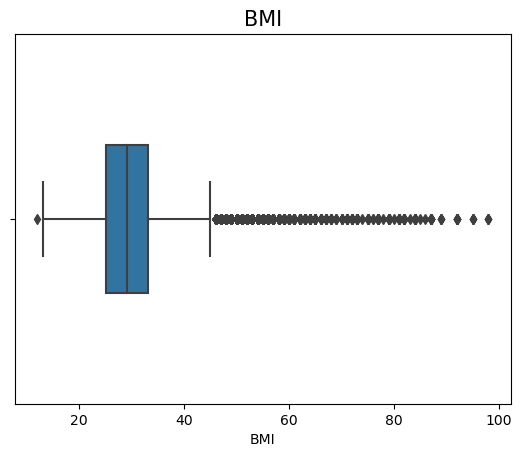

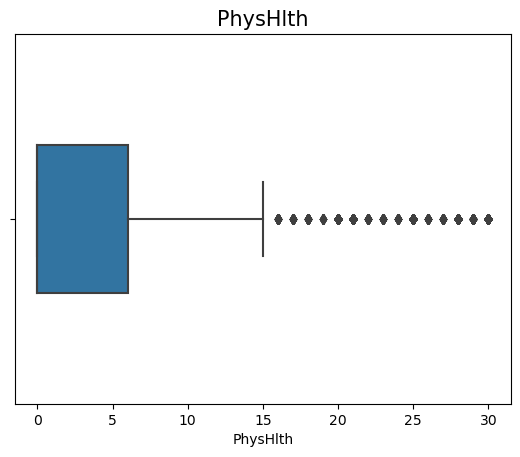

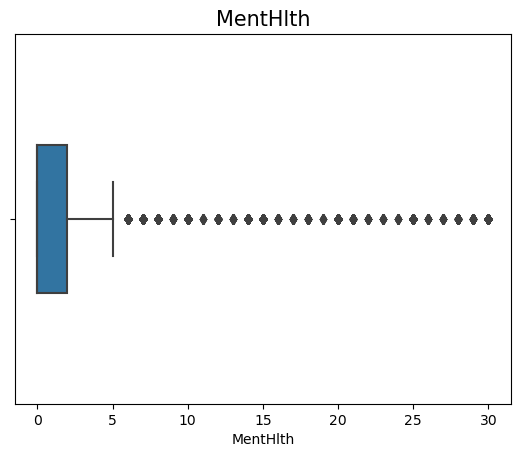

In [18]:
# create a boxplot of numeric columns in the dataset 
for i in range(3):
    boxplot(n_cols[i], cdc_df)

From the above plots, it is apparent (as also seen from the histograms) that PhysHlth and MentHlth are heavily skewed toward fewer days out of the last 30 days. As for BMI, this is roughly distributed evenly with many outliers a high BMIs. This makes sense as BMI is constrained to be above 0. BMI above 65 is rare and corresponds to morbidly obese individuals.

In [19]:
# histogram plotting function with KDE overlay 
# plot mean as a red line 
def hist_plot(x, df):
    sns.distplot(df[x], color='blue')
    plt.title(x)
    plt.xlabel(x)
    plt.ylabel('Frequency')
    plt.axvline(df[x].mean(),color='green');
    plt.show();

For the below plots, the data can be seen in slightly more detail. The distributions are mostly skewed but BMI is closest to being normally distributed.

/tmp/ipykernel_245/3326016103.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[x], color='blue')


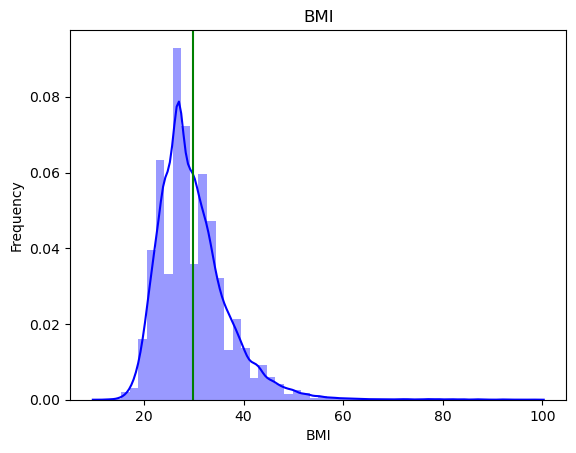

/tmp/ipykernel_245/3326016103.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[x], color='blue')


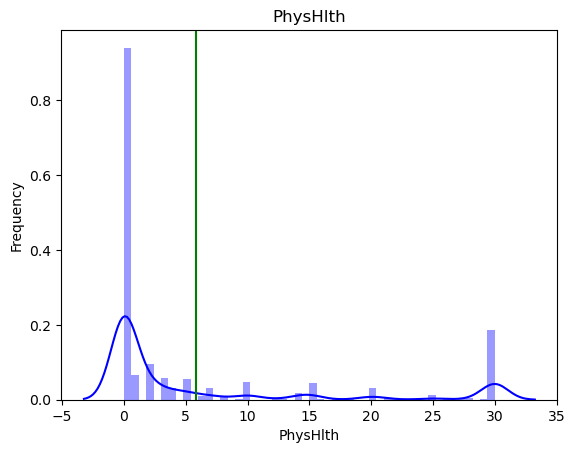

/tmp/ipykernel_245/3326016103.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[x], color='blue')


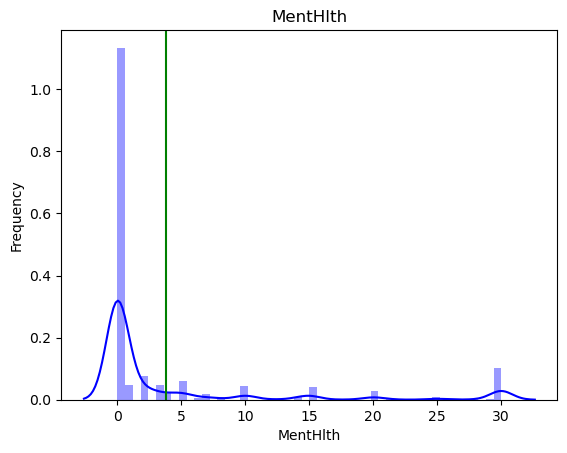

In [20]:
for i in range(3):
    hist_plot(n_cols[i], cdc_df)

## Correlation of Numeric Variables 

/tmp/ipykernel_245/2564525100.py:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation = cdc_df.corr()


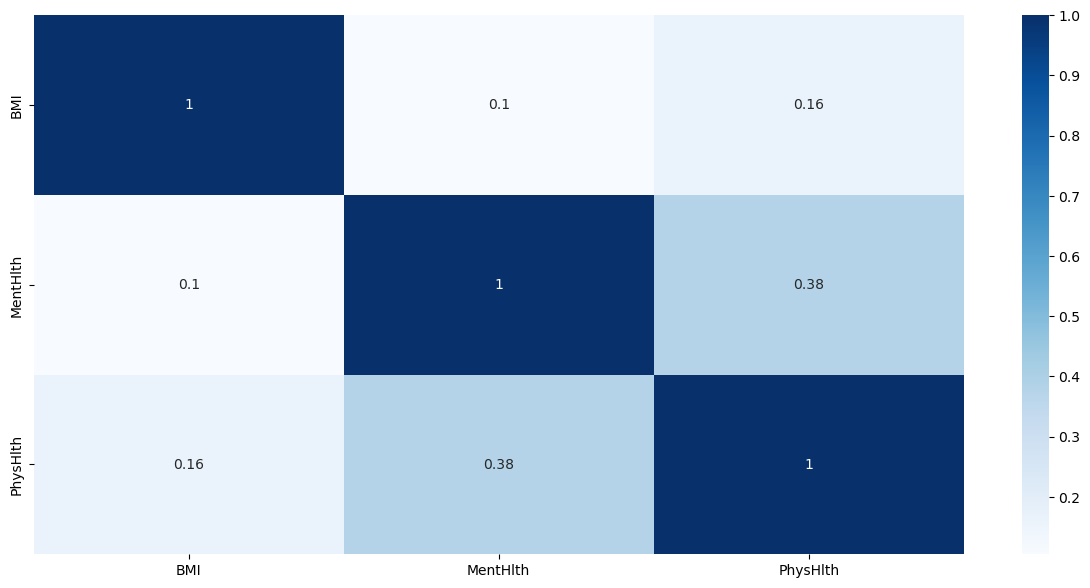

In [21]:
# matrix for correlation between numeric variables 
fig, ax = plt.subplots(figsize=(15,7))
correlation = cdc_df.corr()
sns.heatmap(correlation, xticklabels=correlation.columns, yticklabels=correlation.columns, annot=True, ax=ax, cmap="Blues");

The above is a correlation matrix between the numeric variables. A correlation of 1 indicates perfect positive correlation while -1 indicates perfect negative correlation. Correlation values aside from the diagonals that are roughly above 0.7 might pose a problem and may indicate you don't necessarily need to analyze both of those attributes in the classification problem because of how correlated they are. Correlations between BMI and either PhysHlth or MentHlth are not evident. However, there is a slight positive correlation between MentHlth and PhysHlth but because it is still well below 0.7, it can be considered low enough for both to remain in the classification problem.

## Data Cleaning: Check for missing values
Here, we conduct a quick check for missing values. Because there are no missing values, we can assume that the CDC put measures in place to prevent data from being incomplete. Therefore, we do not need to take any actions. If there were missing values, I would fill in for categorical attributes by entering in the most frequently occurring category. For numerical attributes, I would fill in with the median.

In [22]:
# Count NaNs in cdc dataset. 
cdc_df.isnull().sum()

Diabetes                0
HighBP                  0
HighChol                0
BMI                     0
Smoker                  0
Stroke                  0
HeartDiseaseorAttack    0
PhysActivity            0
Fruits                  0
Veggies                 0
HvyAlcoholConsump       0
AnyHealthcare           0
NoDocbcCost             0
GenHlth                 0
MentHlth                0
PhysHlth                0
DiffWalk                0
Sex                     0
Age                     0
Education               0
Income                  0
dtype: int64

In [23]:
c_cols = ['Diabetes','HighBP', 'HighChol', 'Smoker', 'Stroke', 'HeartDiseaseorAttack', 'Fruits', 'Veggies', 'HvyAlcoholConsump', 'AnyHealthcare', 'NoDocbcCost', 'GenHlth', 'DiffWalk', 'Sex', 'Age', 'Education', 'Income']

In [24]:
def bar_plot(cat, df):
    sns.barplot(x=df[cat].value_counts().index, y=df[cat].value_counts(), alpha=0.8)
    plt.title(cat)
    plt.xlabel(cat)
    plt.ylabel('Frequency')
    plt.show();

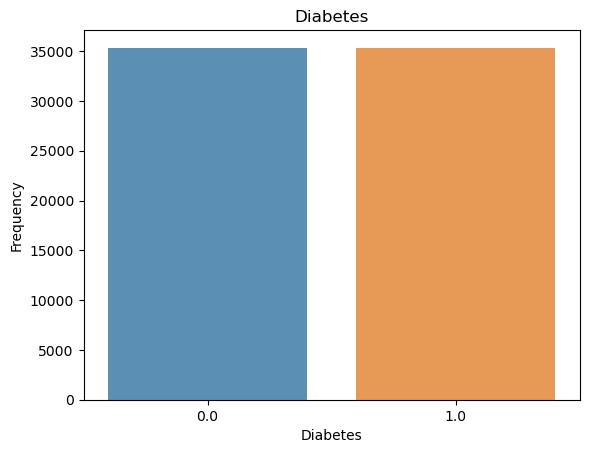

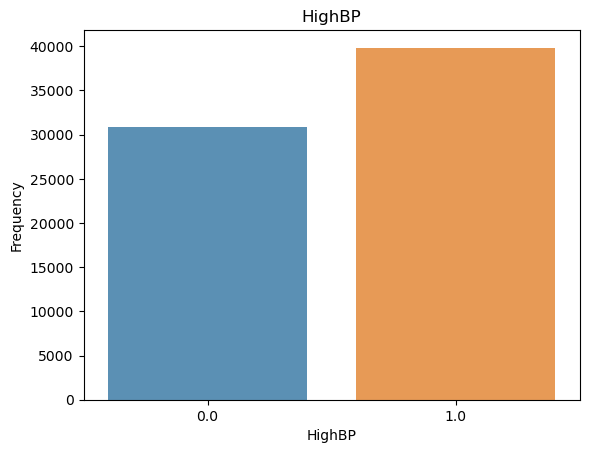

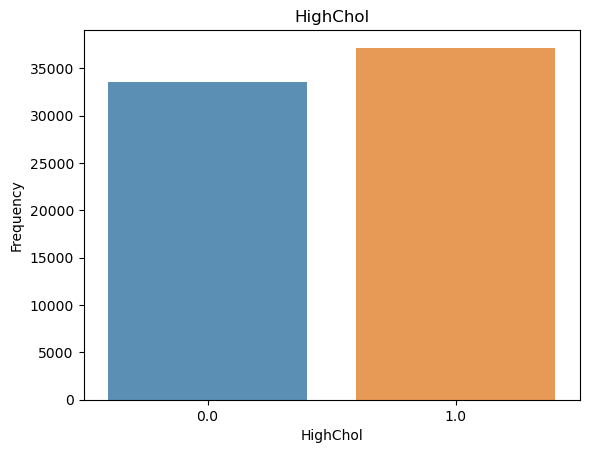

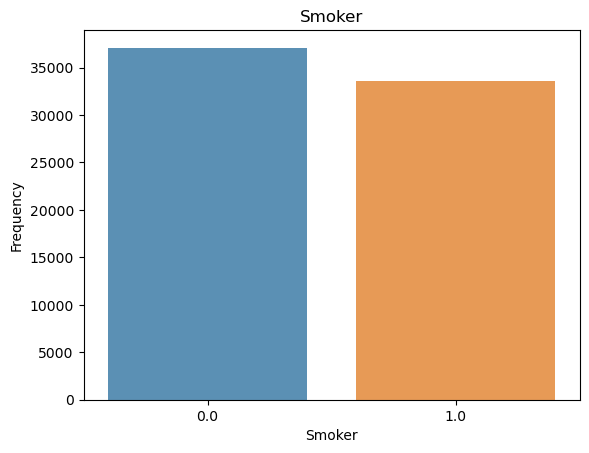

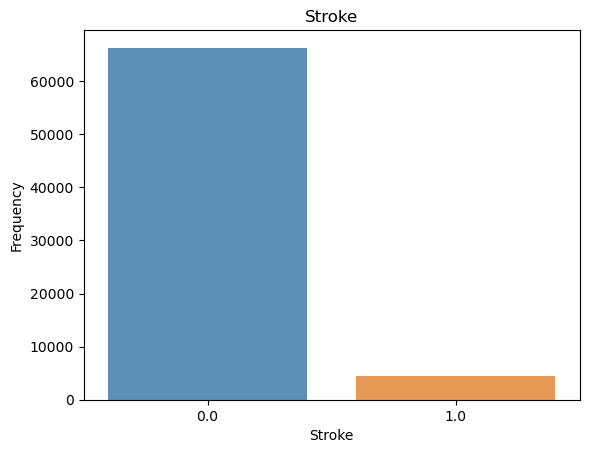

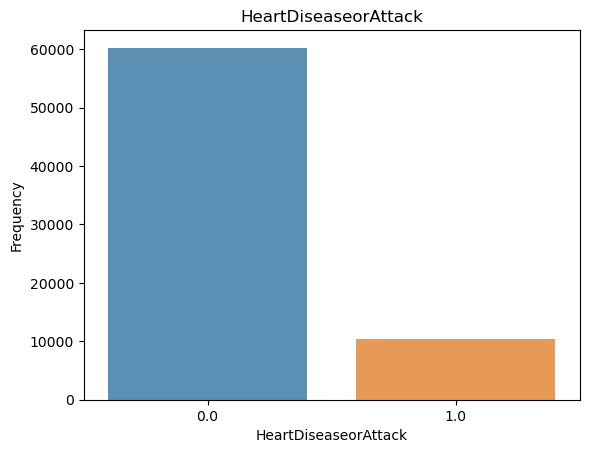

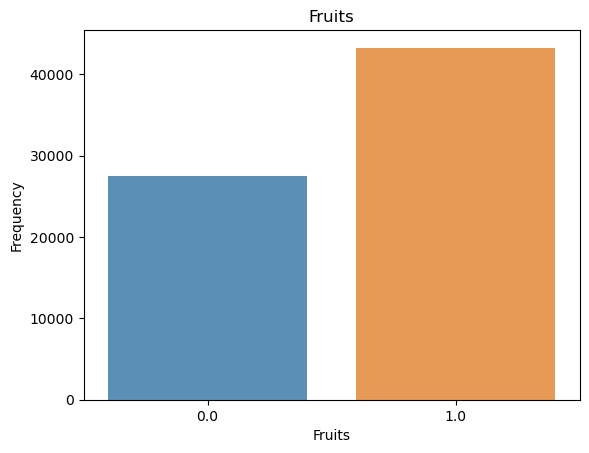

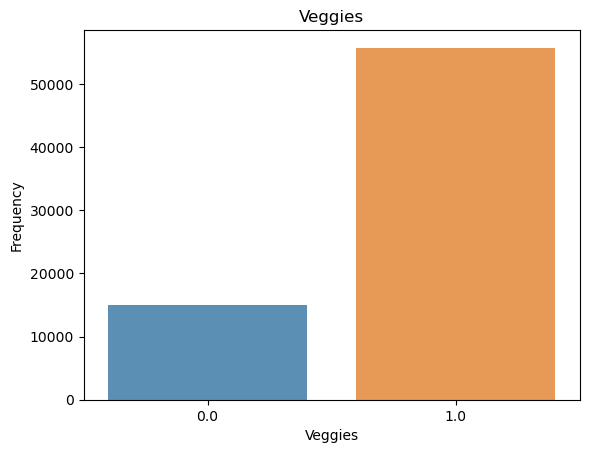

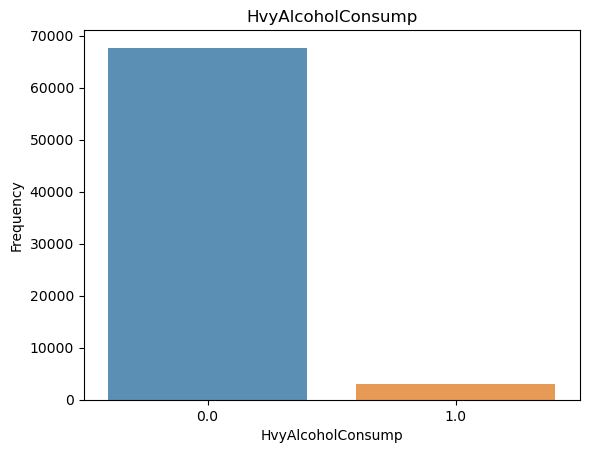

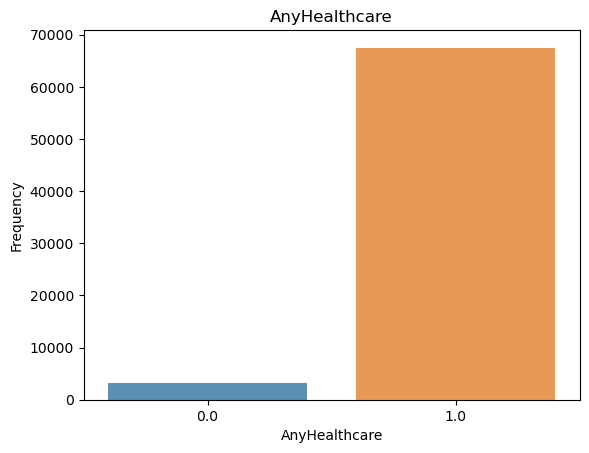

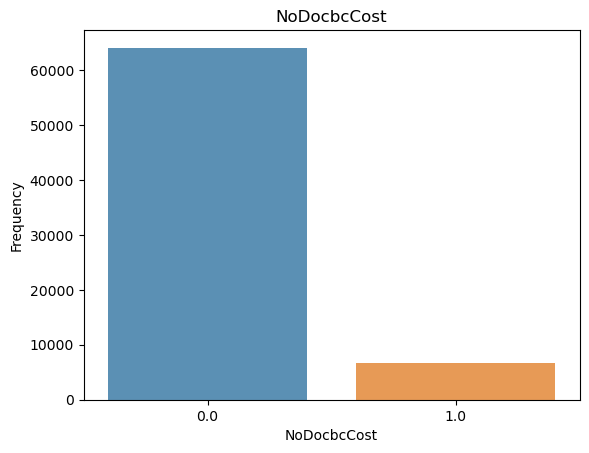

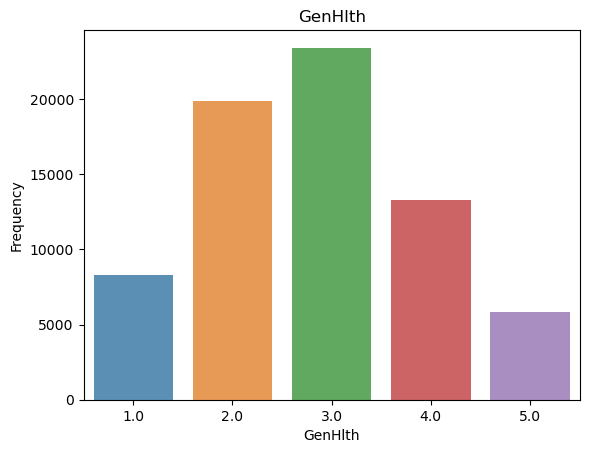

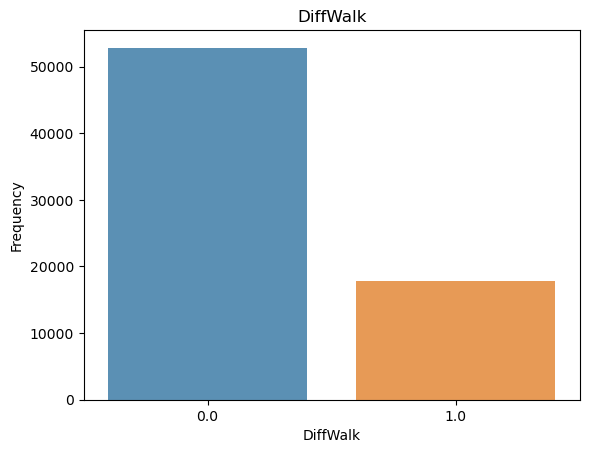

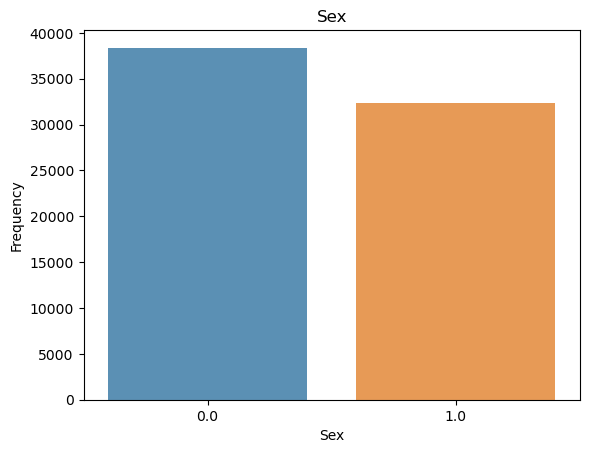

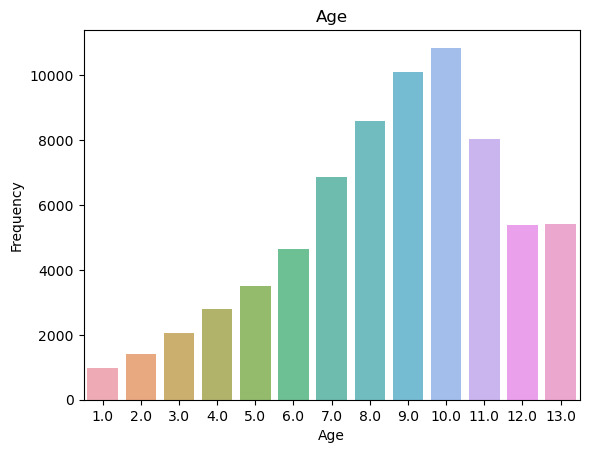

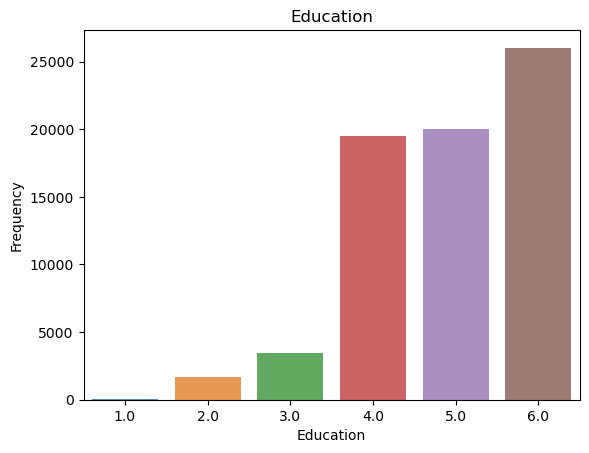

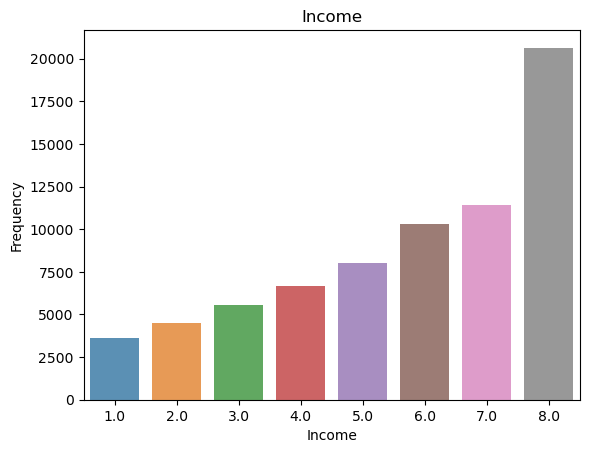

In [25]:
num_cols = len(c_cols)
for i in range(num_cols):
    bar_plot(c_cols[i], cdc_df)

The above plots indicate a clear lack of uniformity. More analysis is needed to determine if further cleaning will be required.
* For the categorical attributes with more than two levels (Income, Education, Age, GenHlth), they are mostly skewed while Age and GenHlth are closest to being normally distributed.
* For the binary attributes, Diabetes, DiffWalk, NoDocbcCost, AnyHealthcare, HvyAlcoholConsump, Veggies, HeartDiseaseorAttack, and Stroke are heavily weighted toward one category. 
* The other binary attributes are closer to being uniformly distributed.

## Correlation of Categorical Variables 
This correlation can be done by interpreting the levels as numerical. Data wrangling describes the process of changing the data format for more appropriate methods of data analysis.

## Data Transformations: Change attributes to numeric
The following code block encodes the categorical attributes as numeric using Label Encoder from sklearn

In [26]:
 
# prep label encoder
encoder = preprocessing.LabelEncoder()

# process all categorical types
for col in cdc_df:
    # only concerned with category variables
    if cdc_df[col].dtypes == 'category':
    # Transformation
        encoder.fit(cdc_df[col])
        cdc_df[col]=encoder.transform(cdc_df[col])

Below double checks that the datatypes were adjusted properly. They should all indicate int64 now.

In [27]:
cdc_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70692 entries, 0 to 70691
Data columns (total 21 columns):
 #   Column                Non-Null Count  Dtype
---  ------                --------------  -----
 0   Diabetes              70692 non-null  int64
 1   HighBP                70692 non-null  int64
 2   HighChol              70692 non-null  int64
 3   BMI                   70692 non-null  int64
 4   Smoker                70692 non-null  int64
 5   Stroke                70692 non-null  int64
 6   HeartDiseaseorAttack  70692 non-null  int64
 7   PhysActivity          70692 non-null  int64
 8   Fruits                70692 non-null  int64
 9   Veggies               70692 non-null  int64
 10  HvyAlcoholConsump     70692 non-null  int64
 11  AnyHealthcare         70692 non-null  int64
 12  NoDocbcCost           70692 non-null  int64
 13  GenHlth               70692 non-null  int64
 14  MentHlth              70692 non-null  int64
 15  PhysHlth              70692 non-null  int64
 16  Diff

Because the following analysis is only focused on categorical attributes, below, I have filtered the dataframe to only include those attributes of interest. There is no concern of there being strange effects of processing due to null values because all nulls have already been checked.

In [28]:
filter_df = cdc_df[c_cols]
filter_df.head()

,Diabetes,HighBP,HighChol,Smoker,Stroke,HeartDiseaseorAttack,Fruits,Veggies,HvyAlcoholConsump,AnyHealthcare,NoDocbcCost,GenHlth,DiffWalk,Sex,Age,Education,Income
0,0,1,0,0,0,0,0,1,0,1,0,2,0,1,3,5,7
1,0,1,1,1,1,0,1,0,0,1,0,2,0,1,11,5,7
2,0,0,0,0,0,0,1,1,0,1,0,0,0,1,12,5,7
3,0,1,1,1,0,0,1,1,0,1,0,2,0,1,10,5,7
4,0,0,0,1,0,0,1,1,0,1,0,1,0,0,7,4,7


In [29]:
# compare each of the categorical predictors with Diabetes
X = filter_df.drop('Diabetes',axis=1)
Y = filter_df['Diabetes']

Chi-Square test statistics are generated below based on comparing to the 'Diabetes' class

In [30]:
# Compute chi-squared statistics between attributes and class
chi_vals, p_vals = chi2(X,Y)
print(chi_vals)

[4.49179996e+03 2.80450128e+03 2.74340616e+02 1.04297634e+03
 2.69540138e+03 8.02508497e+01 9.38835007e+01 6.08852980e+02
 1.71238964e+00 1.07550083e+02 7.92792294e+03 3.92686533e+03
 7.57164613e+01 5.89116113e+03 5.54908738e+02 3.58635597e+03]


In [31]:
filter_list = list(filter_df.drop('Diabetes',axis=1))

The list above is created without the 'Diabetes' class

In [32]:
filter_dict = {}
for i in range(len(filter_list)): 
    filter_dict[filter_list[i]] = chi_vals[i]
print(filter_dict)

{'HighBP': 4491.799959831292, 'HighChol': 2804.5012781530017, 'Smoker': 274.34061551282815, 'Stroke': 1042.9763367463026, 'HeartDiseaseorAttack': 2695.4013781223084, 'Fruits': 80.25084973062961, 'Veggies': 93.88350071736012, 'HvyAlcoholConsump': 608.8529801324503, 'AnyHealthcare': 1.7123896427090122, 'NoDocbcCost': 107.55008284380177, 'GenHlth': 7927.922944242956, 'DiffWalk': 3926.8653307959253, 'Sex': 75.71646133845107, 'Age': 5891.16113196004, 'Education': 554.908738004185, 'Income': 3586.3559748654907}


The section above lays out each of the attributes followed by their corresponding chi square values. Below, each of the p-values is laid out. Because the null hypothesis for each of these tests is that the two attributes are independent, the higher the chi square value (lower the p-value), the more likely that they are actually dependent. This implies that they will have a higher likelihood of impacting classification.

In [33]:
filter_dict2 = {}
for i in range(len(filter_list)): 
    filter_dict2[filter_list[i]] = p_vals[i]
print(filter_dict2)

{'HighBP': 0.0, 'HighChol': 0.0, 'Smoker': 1.2850451658159551e-61, 'Stroke': 8.183772083340152e-229, 'HeartDiseaseorAttack': 0.0, 'Fruits': 3.2977063521101807e-19, 'Veggies': 3.34652091544133e-22, 'HvyAlcoholConsump': 1.9871409285413256e-134, 'AnyHealthcare': 0.19067561989911969, 'NoDocbcCost': 3.3727386477028874e-25, 'GenHlth': 0.0, 'DiffWalk': 0.0, 'Sex': 3.2746622956527183e-18, 'Age': 0.0, 'Education': 1.0768338422321708e-122, 'Income': 0.0}


All of the attributes except 'AnyHealthcare' have a strong indication of dependence based on a significance level of 0.05. That significance level corresponds to roughly a 5.99 chi square value for a 2x2 contingency table. A much lower significance level could have been chosen because the p-values are so low for nearly all attributes.

What should be done based on these tests? Because of how many attributes are being included in this classification, I am choosing to delete the 'AnyHealthcare' attribute from the dataset to focus on the more impactful factors. For reference 'AnyHealthcare' describes if the individual has any form of healthcare or not. We also use the .info() function to verify that 'AnyHealthcare' was removed from the dataset.

In [34]:
cdc_df = cdc_df.drop('AnyHealthcare', axis=1)

In [35]:
cdc_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70692 entries, 0 to 70691
Data columns (total 20 columns):
 #   Column                Non-Null Count  Dtype
---  ------                --------------  -----
 0   Diabetes              70692 non-null  int64
 1   HighBP                70692 non-null  int64
 2   HighChol              70692 non-null  int64
 3   BMI                   70692 non-null  int64
 4   Smoker                70692 non-null  int64
 5   Stroke                70692 non-null  int64
 6   HeartDiseaseorAttack  70692 non-null  int64
 7   PhysActivity          70692 non-null  int64
 8   Fruits                70692 non-null  int64
 9   Veggies               70692 non-null  int64
 10  HvyAlcoholConsump     70692 non-null  int64
 11  NoDocbcCost           70692 non-null  int64
 12  GenHlth               70692 non-null  int64
 13  MentHlth              70692 non-null  int64
 14  PhysHlth              70692 non-null  int64
 15  DiffWalk              70692 non-null  int64
 16  Sex 

## Data Transformations: Data scaling
Most attributes are binary, but there are some that have larger ranges which I plan to scale in the following section. sklearn.preprocessing will be used to transform all attributes to a 0-1 scale.

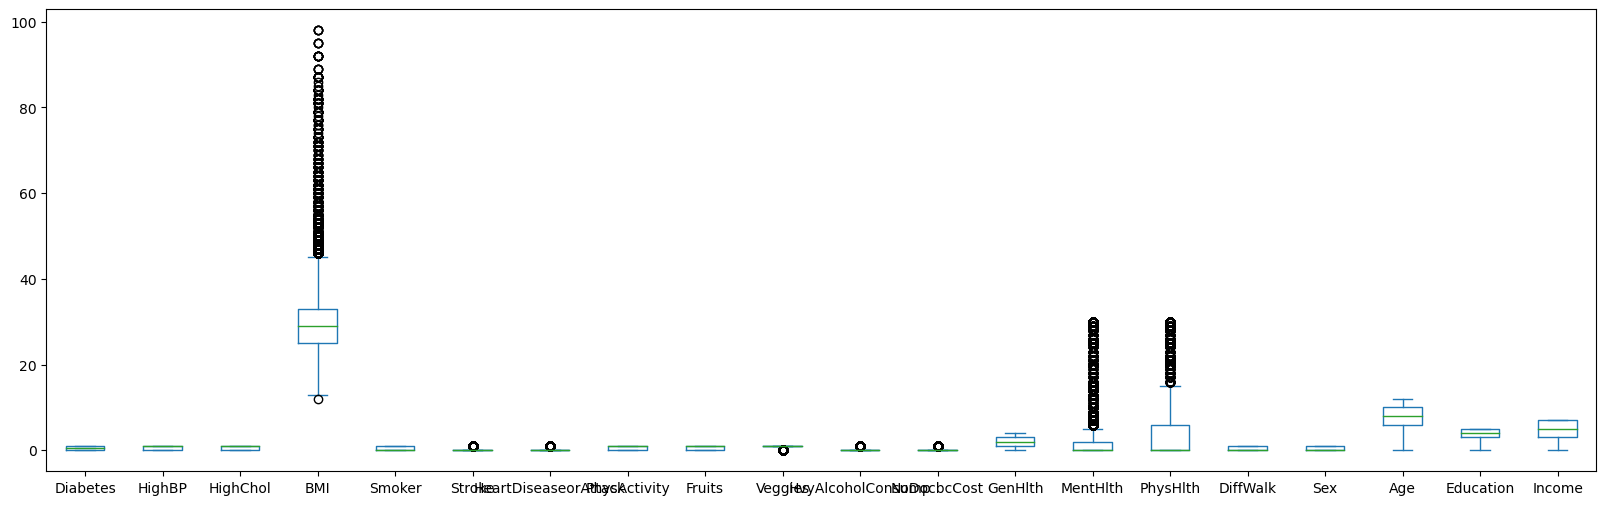

In [36]:
# boxplot for each attribute showing ranges in values 
cdc_df.plot.box(figsize=(20,6));

The above highlights boxplots for each of the attributes in the dataset. Additional work should be done on BMI, MentHlth, and PhysHlth to remove outliers and cause the scaling portion of data processing to be more effective.

## Cleaning:  Outlier Removal 
It is recommended that boxplots should be used to investigate and remove outliers for data that follows roughly a normal distribution. This would involve values less than 1.5 times the Interquartile Range added to Q3 or subtracted from Q1. Because the distributions are all roughly skewed, this is not a robust approach. Visual inspection will be used in the following step using strip plots.

## Outlier Inspection
Below are a set of strip plots for the non-binary attributes in the dataset. The non-binary attributes are chosen because there is potential for outliers to be present in those attributes which could negatively impact the scaling of those factors.

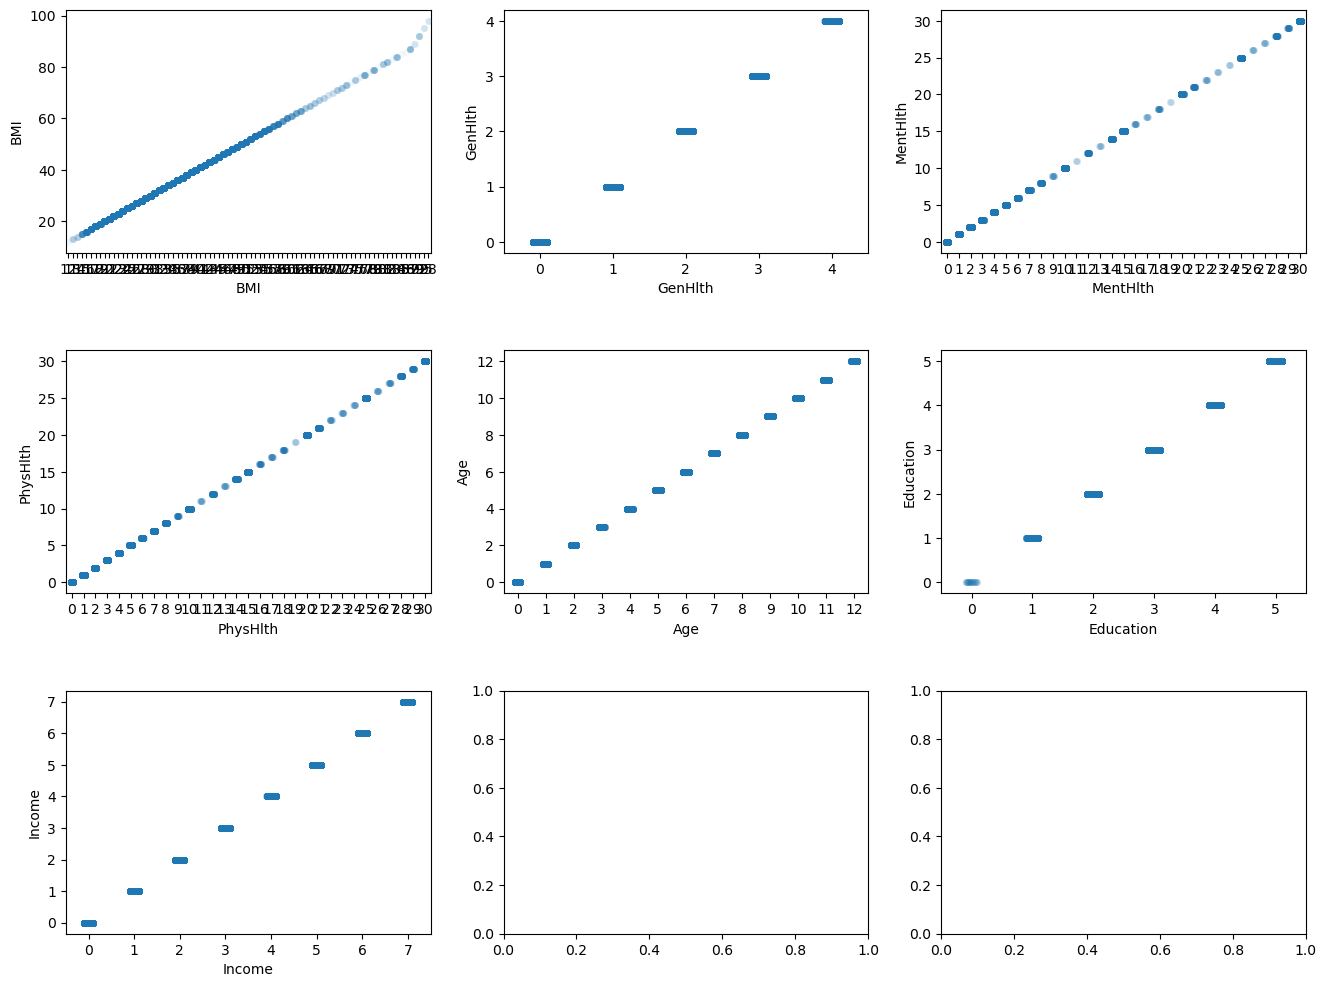

In [37]:
non_binary_cols = ['BMI', 'GenHlth', 'MentHlth', 'PhysHlth', 'Age', 'Education','Income']
fig,ax = plt.subplots(nrows=3,ncols=3,figsize=(16,12))
plt.subplots_adjust(hspace=0.4)
x = 0
for i in range(3):
    for j in range(3):
        if x == 7:
            break
        sns.stripplot(x=cdc_df[non_binary_cols[x]],y=cdc_df[non_binary_cols[x]], data=cdc_df, jitter=True, alpha=0.05, ax=ax[i][j])
        ax[i][j].set_xlabel(non_binary_cols[x])
        x += 1

The determination of outliers is somewhat arbitrary but from the strip plots, it appears that very few individuals report BMI's greater than 80. Considering that the largest recorded BMI is just above 100 and those designated as 'morbidly obese' occurs at around 65, it would be appropriate to cap the BMI at 80 in this dataset. All other attributes do not appear to have many outliers. The following section will clean up outliers above a value of 80 in the dataset.

## Outlier Cleaning 

Below is the benchmarked number of data records prior to cleaning:

In [38]:
# benchmark
cdc_len_i = len(cdc_df)
print(cdc_len_i)

70692


The following code block locates all records that we are attempting to clean up (that have BMI's greater than 80). A preview of those records is shown.

In [39]:
outliers = cdc_df.loc[(cdc_df['BMI'] > 80)]
idx_lst = list(outliers.index)
num_outliers = len(idx_lst)
outliers.head()

,Diabetes,HighBP,HighChol,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,Veggies,HvyAlcoholConsump,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income
553,0,0,0,92,1,0,0,1,1,1,0,1,1,30,0,0,0,1,3,6
612,0,0,1,98,1,0,0,1,1,1,0,0,1,0,20,0,0,9,5,6
2702,0,0,1,84,0,0,0,1,1,0,0,0,1,0,0,0,0,7,5,7
5762,0,0,0,84,1,0,0,0,0,0,0,0,1,0,30,0,1,12,2,3
5858,0,1,1,84,1,0,0,1,1,1,0,0,1,0,0,1,0,11,3,4


In [40]:
print('Number of outliers to clean up: ', num_outliers)
print("Percentage of data records to be removed: {0:.3g}%".format((num_outliers/cdc_len_i) * 100))

Number of outliers to clean up:  70
Percentage of data records to be removed: 0.099%


The above number of 70 (0.099% of dataset) is such a low number of records to clean up. This confirms that these are extreme cases and should help the scaling portion of this problem be more effective. The following code block creates a cleaned up dataframe with those outliers removed.

In [41]:
clean_df = cdc_df.drop(idx_lst)

## Training and Testing Sets
Scaling is to be done after splitting the sets as it is dependent on the characteristics of the data in the set. The classes are already split evenly so there does not need to be much concern about oversampling or undersampling one class over the other.

The dataframe is converted to numpy arrays and sampled in the following blocks.

In [42]:
#numpy array conversion
clean_np = clean_df.values

# features/labels
X,Y = clean_np[:,1:20] , clean_np[:,0]

# Split into train and test sets
X_train, X_test, Y_train, Y_test = train_test_split(X, Y,test_size=0.45,random_state=42)

In [43]:
# shape of train and test datasets
print(X_train.shape)
print(X_test.shape)
print(Y_train.shape)
print(Y_test.shape)

(38842, 19)
(31780, 19)
(38842,)
(31780,)


## Scale to 0 to 1 Range 

MinMaxScaler is used to scale the training and test sets.

In [44]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_train = scaler.fit_transform(X_train)
scaled_test = scaler.fit_transform(X_test)

## Compare Classes
The following generates a series of boxplots containing only the numeric features that is split by Diabetes or No Diabetes. This will help visualize if there is some variation in the class split.

In [45]:
n_cols = ['BMI', 'PhysHlth', 'MentHlth', 
               'Diabetes']

In [46]:
# create filtered version of DataFrame 
# only has numeric columns
numeric_df_clean = clean_df[n_cols]
numeric_df_clean.head()

,BMI,PhysHlth,MentHlth,Diabetes
0,26,30,5,0
1,26,0,0,0
2,26,10,0,0
3,28,3,0,0
4,29,0,0,0


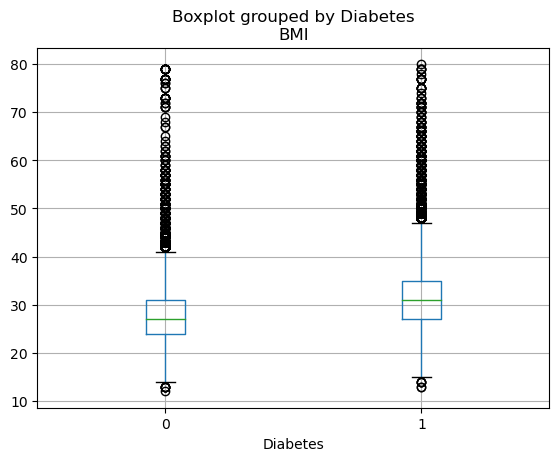

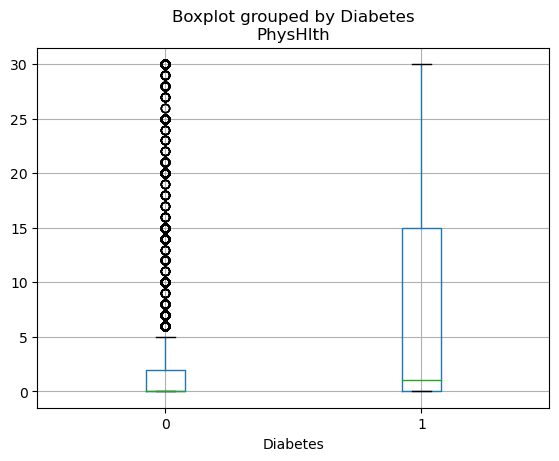

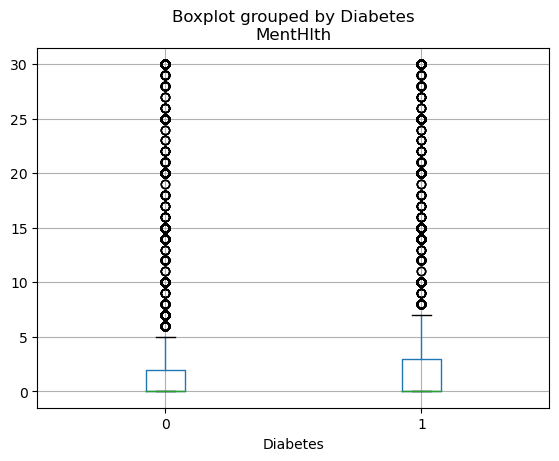

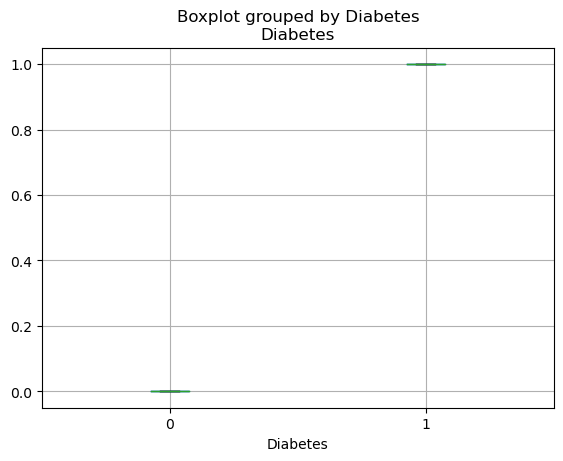

In [47]:
# create boxplots for each numeric attribute
# grouped by approval status 
for i in n_cols:
    numeric_df_clean.boxplot(column=i, by='Diabetes')

As seen above, it is evident that there is potential for there to be significant differences between those at different BMI's and overall Physical Health and likelihood of having diabetes.

## Cleaning/Exploratory Data Analysis Summary
* Checked for null values
* Transformed categorical values to numeric values
* Scaled data to 0-1 scale to aid with effectiveness of KNN method
* Cleaned outliers present in BMI class
* Removed a couple attributes that were either redundant or appeared to have no correlation with the Diabetes class
* Investigated correlation between variables

## Models Proposed and Potential Difficulties:

Linear Regression: This approach will simply classify for a given X input (set of attributes) the predicted Y output as Diabetes if it is predicted to be above 0.5 or No Diabetes if it is under 0.5. Scaling the data along with the presence of several binary attributes should indicate that linear regression will be a good model. Based on the amount of noise from plotted attributes along with relatively lower correlation coefficients across many of the health indicators, could mean that the combination of attribute values may be more meaningful than examining only a few attributes. However, logistic regression may be more fitting for binary outcomes because linear regression has the potential to produce values less than 0 or more than 1.

Logistic Regression: This model will only generate values greater than 0 and less than 1. This model will also produce the probability of a certain classification. However, correlation between some of the attributes, which is likely in a healthcare setting, could impact the success of this model. It cannnot be assumed that the attributes are independent from one another. GridSearching could be used to help with the success of this model.

KNN: Nearest neighbor models determines a class for a given input based on nearest neighbor averaging. This becomes much more computationally intense with larger p which is the case with this data. However, it does well at larger n which is the case with this data. Depending on how many neighbors are selected, it could take a lot of computations to generate accurate results.

I plan to try all the models above and perhaps additional ones if the success rate is still not great.

## Models and Results

## Model 1: Linear Regression

Why am I considering this model for classification?
* Simple linear regression can be effective for binary classification tasks because integers can be coded to the class outcomes, and a threshold of 0.5 can be used to determine the prediction.

What are the potential difficulties?
* This model may produce results less than zero or greater than 1 so a different model may be more appropriate.
* Also, as shown in the correlation matrix, there aren't any obvious indicators that have coefficients above 0.5 or 0.6. Therefore, a simple model may be unable to effectively capture the effects of each indicator if some of the indicators are dependent on each other.

In [48]:
#Prepare for linear regression analysis
factors = ['HighBP', 'HighChol', 'BMI', 'Smoker', 'Stroke', 'HeartDiseaseorAttack', 'PhysActivity', 'Fruits', 'Veggies', 'HvyAlcoholConsump', 'NoDocbcCost', 'GenHlth', 'MentHlth', 'PhysHlth', 'DiffWalk', 'Sex', 'Age', 'Education', 'Income']

In [49]:
# create dataframe generated from rescaled training set.
xdf_train = pd.DataFrame(data = scaled_train, columns = factors)
print(xdf_train.head())

   HighBP  HighChol       BMI  Smoker  Stroke  HeartDiseaseorAttack  \
0     1.0       1.0  0.149254     1.0     0.0                   0.0   
1     1.0       1.0  0.373134     0.0     0.0                   0.0   
2     0.0       0.0  0.417910     0.0     0.0                   0.0   
3     1.0       1.0  0.328358     1.0     0.0                   1.0   
4     0.0       0.0  0.328358     1.0     0.0                   0.0   

   PhysActivity  Fruits  Veggies  HvyAlcoholConsump  NoDocbcCost  GenHlth  \
0           0.0     1.0      1.0                0.0          0.0     0.25   
1           0.0     0.0      0.0                0.0          0.0     1.00   
2           0.0     1.0      1.0                0.0          0.0     0.75   
3           1.0     0.0      1.0                0.0          0.0     0.25   
4           1.0     0.0      0.0                0.0          1.0     0.25   

   MentHlth  PhysHlth  DiffWalk  Sex       Age  Education    Income  
0  0.000000  0.000000       0.0  1.0  0.

In [50]:
# training series with approval status
ydf_train = pd.DataFrame(data = Y_train, columns=['Diabetes']) 
print(ydf_train.head())

   Diabetes
0         0
1         1
2         1
3         1
4         0


In [51]:
#reform dataframe with complete data.
df_train = pd.concat([xdf_train, ydf_train], axis=1, sort=False)
print(df_train.head())

   HighBP  HighChol       BMI  Smoker  Stroke  HeartDiseaseorAttack  \
0     1.0       1.0  0.149254     1.0     0.0                   0.0   
1     1.0       1.0  0.373134     0.0     0.0                   0.0   
2     0.0       0.0  0.417910     0.0     0.0                   0.0   
3     1.0       1.0  0.328358     1.0     0.0                   1.0   
4     0.0       0.0  0.328358     1.0     0.0                   0.0   

   PhysActivity  Fruits  Veggies  HvyAlcoholConsump  NoDocbcCost  GenHlth  \
0           0.0     1.0      1.0                0.0          0.0     0.25   
1           0.0     0.0      0.0                0.0          0.0     1.00   
2           0.0     1.0      1.0                0.0          0.0     0.75   
3           1.0     0.0      1.0                0.0          0.0     0.25   
4           1.0     0.0      0.0                0.0          1.0     0.25   

   MentHlth  PhysHlth  DiffWalk  Sex       Age  Education    Income  Diabetes  
0  0.000000  0.000000       0.

In [52]:
# Now, repeat for test data in addition to training data.
xdf_test = pd.DataFrame(data = scaled_test, columns = factors)
print(xdf_test.head())

   HighBP  HighChol       BMI  Smoker  Stroke  HeartDiseaseorAttack  \
0     1.0       1.0  0.358209     1.0     0.0                   0.0   
1     0.0       0.0  0.313433     1.0     0.0                   0.0   
2     1.0       0.0  0.328358     1.0     0.0                   0.0   
3     1.0       0.0  0.194030     1.0     0.0                   0.0   
4     0.0       0.0  0.253731     0.0     0.0                   0.0   

   PhysActivity  Fruits  Veggies  HvyAlcoholConsump  NoDocbcCost  GenHlth  \
0           0.0     0.0      1.0                0.0          0.0     0.25   
1           1.0     1.0      1.0                0.0          0.0     0.25   
2           1.0     1.0      1.0                0.0          0.0     0.50   
3           0.0     0.0      1.0                0.0          0.0     0.25   
4           1.0     1.0      1.0                0.0          0.0     0.50   

   MentHlth  PhysHlth  DiffWalk  Sex       Age  Education    Income  
0       0.0  0.100000       1.0  1.0  0.

In [53]:
ydf_test = pd.DataFrame(data = Y_test, columns = ['Diabetes']) 
print(ydf_test.head())

   Diabetes
0         1
1         0
2         1
3         0
4         0


In [54]:
df_test = pd.concat([xdf_test, ydf_test], axis=1, sort=False)
print(df_test.head())

   HighBP  HighChol       BMI  Smoker  Stroke  HeartDiseaseorAttack  \
0     1.0       1.0  0.358209     1.0     0.0                   0.0   
1     0.0       0.0  0.313433     1.0     0.0                   0.0   
2     1.0       0.0  0.328358     1.0     0.0                   0.0   
3     1.0       0.0  0.194030     1.0     0.0                   0.0   
4     0.0       0.0  0.253731     0.0     0.0                   0.0   

   PhysActivity  Fruits  Veggies  HvyAlcoholConsump  NoDocbcCost  GenHlth  \
0           0.0     0.0      1.0                0.0          0.0     0.25   
1           1.0     1.0      1.0                0.0          0.0     0.25   
2           1.0     1.0      1.0                0.0          0.0     0.50   
3           0.0     0.0      1.0                0.0          0.0     0.25   
4           1.0     1.0      1.0                0.0          0.0     0.50   

   MentHlth  PhysHlth  DiffWalk  Sex       Age  Education    Income  Diabetes  
0       0.0  0.100000       1.

In [55]:
#Statsmodel implementation of linear regression model for diabetes with respect to individual factors
#Training step
for factor in factors:
    model = smf.ols(formula = 'Diabetes~' + factor, data = df_train).fit()
    print('Dependent variable: ' + factor)
    print(model.summary())
    print(model.params[0])
    print(model.params[1])

Dependent variable: HighBP
                            OLS Regression Results                            
Dep. Variable:               Diabetes   R-squared:                       0.147
Model:                            OLS   Adj. R-squared:                  0.147
Method:                 Least Squares   F-statistic:                     6693.
Date:                Thu, 03 Aug 2023   Prob (F-statistic):               0.00
Time:                        02:05:58   Log-Likelihood:                -25104.
No. Observations:               38842   AIC:                         5.021e+04
Df Residuals:                   38840   BIC:                         5.023e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.2806    

## Results from Basic Linear Regression

The R-squared value is key for demonstrating how well the model fits the given dataset. This measures how much variance can be explained by the model. Higher R-squared values indicate better fit, with the maximum being 1. From the examined factors, the factor with the highest R-squared value is 0.164 for the 'GenHlth' attribute. Because this is very far from 1, I will not pursue additional analysis of basic linear regression. Instead, I will investigate Multiple Linear Regression.

## Model 1 Extension: Multiple Linear Regression
Multiple linear regression or multilinear regression utilizes a hyperplane to predict output based on as many factors as desired. The greater the impact of a factor, the larger the coefficient. Ideally, factors are uncorrelated. This can be further investigated by considering collinearity. 

In [56]:
#Define formula for multilinear regression:
multilin = 'HighBP+HighChol+BMI+Smoker+Stroke+HeartDiseaseorAttack+PhysActivity+Fruits+Veggies+HvyAlcoholConsump+NoDocbcCost+GenHlth+MentHlth+PhysHlth+DiffWalk+Sex+Age+Education+Income'

In [57]:
# Creation of multilinear model with all factors and find coefficients that reduce the sum of least squares 
multilin_model = smf.ols(formula = 'Diabetes ~' + multilin, data = df_train).fit()
print(multilin_model.summary())

                            OLS Regression Results                            
Dep. Variable:               Diabetes   R-squared:                       0.307
Model:                            OLS   Adj. R-squared:                  0.307
Method:                 Least Squares   F-statistic:                     905.2
Date:                Thu, 03 Aug 2023   Prob (F-statistic):               0.00
Time:                        02:06:03   Log-Likelihood:                -21069.
No. Observations:               38842   AIC:                         4.218e+04
Df Residuals:                   38822   BIC:                         4.235e+04
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept               -0.1973 

Some observations from the multilinear model with all parameters:
* The R-squared value in this case was higher than all previous models with single factors.
* In the case of all factors represented, the following factors did not have significant effects in the model according to a p-value of 0.05: Smoker, PhysActivity, Fruits, Veggies, and NoDocbcCost. Their confidence intervals included the value of 0.
* The remainder of the factors can be considered important according to a p-value of 0.05: HighBP, HighChol, BMI, Stroke, HeartDiseaseorAttach, HvyAlcoholConsump, GenHlth, MentHlth, DiffWalk, Sex, Age, Education, and Income. Their confidence intervals do not include 0.

In [58]:
# returns prediction using coefficients from the multilinear model
def multilinear_regression_formula(predictors,params, df):
    y_hat = params[0]
    c = 1
    for i in predictors:
        y_hat += params[c]*df[i]
    return y_hat

In [59]:
# test DataFrame to be manipulated for multilinear model
df_multilin = df_test.copy()

# Generate parameters from multilinear model
multilin_factors = multilin_model.params
print(multilin_factors)

Intercept              -0.197330
HighBP                  0.156033
HighChol                0.113698
BMI                     0.850336
Smoker                  0.002567
Stroke                  0.021423
HeartDiseaseorAttack    0.048993
PhysActivity            0.000083
Fruits                 -0.004358
Veggies                -0.006988
HvyAlcoholConsump      -0.113234
NoDocbcCost            -0.013408
GenHlth                 0.414794
MentHlth               -0.030335
PhysHlth               -0.047268
DiffWalk                0.038529
Sex                     0.042288
Age                     0.302372
Education              -0.033435
Income                 -0.066988
dtype: float64


In [60]:
# Generate numerical predictions based on multilinear model:
yhat = multilin_factors[0]
for i in range(len(factors)):
    yhat += multilin_factors[i+1]*df_multilin[factors[i]]
df_multilin['yhat'] = yhat

#Generate categorical predictions based on yhat column. 0.5 is threshold.
df_multilin.loc[:,'Prediction'] = np.where(df_multilin['yhat'] >= 0.5, 1.0, 0.0)
print(df_multilin.head())

   HighBP  HighChol       BMI  Smoker  Stroke  HeartDiseaseorAttack  \
0     1.0       1.0  0.358209     1.0     0.0                   0.0   
1     0.0       0.0  0.313433     1.0     0.0                   0.0   
2     1.0       0.0  0.328358     1.0     0.0                   0.0   
3     1.0       0.0  0.194030     1.0     0.0                   0.0   
4     0.0       0.0  0.253731     0.0     0.0                   0.0   

   PhysActivity  Fruits  Veggies  HvyAlcoholConsump  ...  MentHlth  PhysHlth  \
0           0.0     0.0      1.0                0.0  ...       0.0  0.100000   
1           1.0     1.0      1.0                0.0  ...       0.0  0.100000   
2           1.0     1.0      1.0                0.0  ...       0.0  0.033333   
3           0.0     0.0      1.0                0.0  ...       0.0  0.033333   
4           1.0     1.0      1.0                0.0  ...       0.0  0.000000   

   DiffWalk  Sex       Age  Education    Income  Diabetes      yhat  \
0       1.0  1.0  0.4

## Results and Analysis for Multiple Linear Regression

Below is a classification report with evaluation metrics. They include accuracy, precision, recall, and f1 score.

In [61]:
print(classification_report(df_multilin['Diabetes'], df_multilin['Prediction'], zero_division=0))

              precision    recall  f1-score   support

           0       0.75      0.74      0.74     15873
           1       0.74      0.75      0.75     15907

    accuracy                           0.75     31780
   macro avg       0.75      0.75      0.75     31780
weighted avg       0.75      0.75      0.75     31780



In [62]:
#create helper function to create a more effective heatmap.
def heatmap(cmatrix): 
    #1 for diabetes, 0 for no diabetes
    fig, ax = plt.subplots()
    tick_marks = np.arange(2)
    plt.xticks(tick_marks)
    plt.yticks(tick_marks)
    sns.heatmap(pd.DataFrame(cmatrix), annot=True, cmap="YlGnBu" ,fmt='g')
    ax.xaxis.set_label_position("top")
    plt.tight_layout()
    plt.title('Confusion Matrix', y=1.1)
    plt.ylabel('Actual Class')
    plt.xlabel('Predicted Class')
    plt.show()

Below is a confusion matrix that is converted to a heatmap using sklearn.

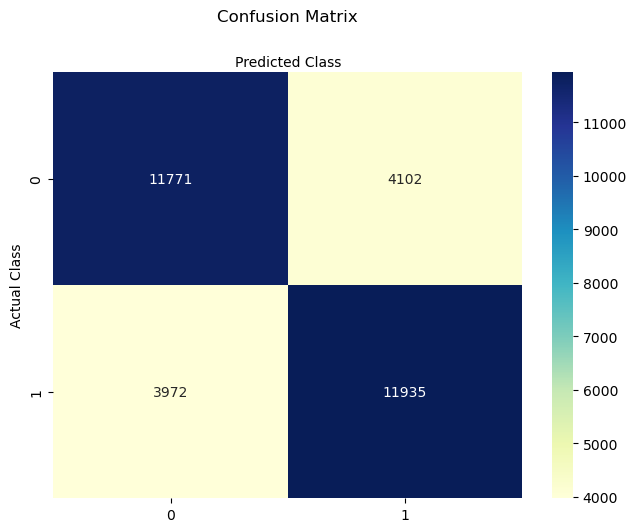

In [63]:
conf_matrix = metrics.confusion_matrix(df_multilin['Diabetes'], df_multilin['Prediction'])
heatmap(conf_matrix)

The yielded accuracy of ~75% indicates a reasonable model to use as it performs extremely well on the test dataset. Next, an ROC curve will be plotted to further determine the model's performance.

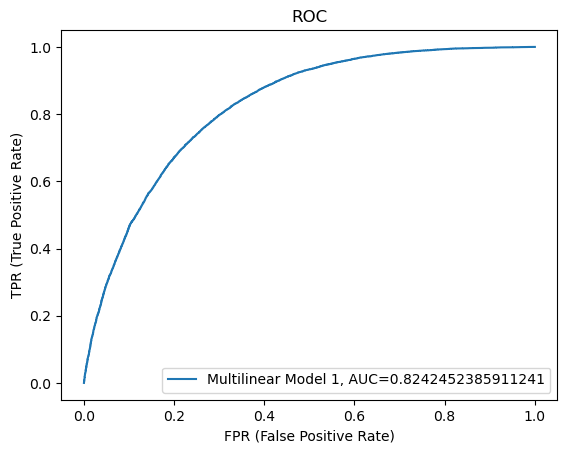

In [64]:
# ROC curve
FPR, TPR, _ = metrics.roc_curve(df_multilin['Diabetes'],  df_multilin['yhat'])
AUC = metrics.roc_auc_score(df_multilin['Diabetes'], df_multilin['yhat'])
plt.plot(FPR,TPR,label="Multilinear Model 1, AUC="+str(AUC))
plt.legend()
plt.title('ROC')
plt.xlabel('FPR (False Positive Rate)')
plt.ylabel('TPR (True Positive Rate)')
plt.show()

Ideally, the ROC curve would be pushed up as far into the left corner as possible which is not entirely the case here but the shape is promising. Combined with the good accuracy numbers, the model is reasonably fitted. The model does significantly better than random 50/50 probability. However, with so many factors and unknown risks of correlation between factors, there is serious potential of correlation between several factors. Therefore, in the next section, we address the risks of collinearity.

## Addressing Collinearity 
Collinearity describes highly correlated factors. A correlation matrix is shown below for the entire dataset. As a note, for a correlation matrix not on the diagonal, correlations of around 0.4 or higher may indicate a collinearity issue. Some potential collinearity issues may exist between the following factors:
* GenHlth with DiffWalk - 0.48
* GenHlth with PhysHlth - 0.55
* PhysHlth with DiffWalk - 0.49
* Education with Income - 0.46
* MentHlth with PhysHlth - 0.38

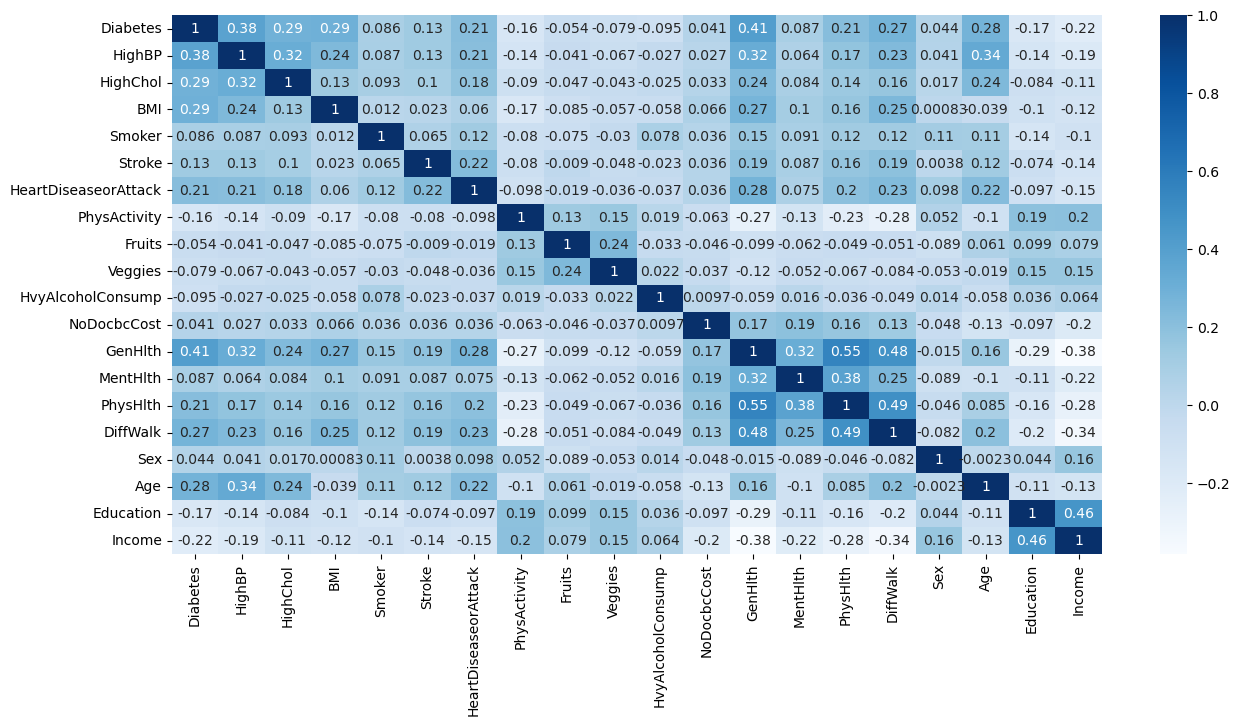

In [65]:
# Plot correlation matrix for all factors
fig, ax = plt.subplots(figsize=(15,7))
correlation = cdc_df.corr()
sns.heatmap(correlation, xticklabels=correlation.columns, yticklabels=correlation.columns, annot=True, ax=ax, cmap="Blues");

The next step is to remove several of the correlated factors above as they are redundant if highly correlated. I decided to drop GenHlth, MenthHlth, Education, and DiffWalk while keeping PhysHlth and Income.

In [66]:
# Created new set of factors free from potential correlation issues
factors_new = ['HighBP', 'HighChol', 'BMI', 'Smoker', 'Stroke', 'HeartDiseaseorAttack', 'PhysActivity', 'Fruits', 'Veggies', 'HvyAlcoholConsump', 'NoDocbcCost', 'PhysHlth', 'Sex', 'Age', 'Income']
multilin_new = 'HighBP+HighChol+BMI+Smoker+Stroke+HeartDiseaseorAttack+PhysActivity+Fruits+Veggies+HvyAlcoholConsump+NoDocbcCost+PhysHlth+Sex+Age+Income'

## Rerun Multilinear Model with Correlated Predictors Removed

In [67]:
# create multilinear model with correlated variables removed 
multilin_new_model = smf.ols(formula = 'Diabetes ~' + multilin_new, data = df_train).fit()
print(multilin_new_model.summary())

                            OLS Regression Results                            
Dep. Variable:               Diabetes   R-squared:                       0.275
Model:                            OLS   Adj. R-squared:                  0.275
Method:                 Least Squares   F-statistic:                     984.1
Date:                Thu, 03 Aug 2023   Prob (F-statistic):               0.00
Time:                        02:06:05   Log-Likelihood:                -21933.
No. Observations:               38842   AIC:                         4.390e+04
Df Residuals:                   38826   BIC:                         4.404e+04
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept               -0.0723 

In [68]:
# create a test DataFrame
new_corr_df = df_test.copy()

# make predictions on the test set
new_corr_params = multilin_new_model.params
print(new_corr_params)

Intercept              -0.072321
HighBP                  0.184087
HighChol                0.129063
BMI                     1.011071
Smoker                  0.013645
Stroke                  0.045133
HeartDiseaseorAttack    0.082899
PhysActivity           -0.023609
Fruits                 -0.009466
Veggies                -0.013239
HvyAlcoholConsump      -0.125934
NoDocbcCost             0.008723
PhysHlth                0.097344
Sex                     0.043927
Age                     0.325721
Income                 -0.146580
dtype: float64


In [69]:
# Generate numerical predictions based on new multilinear model:
yhat = new_corr_params[0]
for i in range(len(factors_new)):
    yhat += new_corr_params[i+1]*new_corr_df[factors_new[i]]
new_corr_df['yhat'] = yhat

#Generate categorical predictions based on yhat column. 0.5 is threshold.
new_corr_df.loc[:,'Prediction'] = np.where(new_corr_df['yhat'] >= 0.5, 1.0, 0.0)
print(new_corr_df.head())

   HighBP  HighChol       BMI  Smoker  Stroke  HeartDiseaseorAttack  \
0     1.0       1.0  0.358209     1.0     0.0                   0.0   
1     0.0       0.0  0.313433     1.0     0.0                   0.0   
2     1.0       0.0  0.328358     1.0     0.0                   0.0   
3     1.0       0.0  0.194030     1.0     0.0                   0.0   
4     0.0       0.0  0.253731     0.0     0.0                   0.0   

   PhysActivity  Fruits  Veggies  HvyAlcoholConsump  ...  MentHlth  PhysHlth  \
0           0.0     0.0      1.0                0.0  ...       0.0  0.100000   
1           1.0     1.0      1.0                0.0  ...       0.0  0.100000   
2           1.0     1.0      1.0                0.0  ...       0.0  0.033333   
3           0.0     0.0      1.0                0.0  ...       0.0  0.033333   
4           1.0     1.0      1.0                0.0  ...       0.0  0.000000   

   DiffWalk  Sex       Age  Education    Income  Diabetes      yhat  \
0       1.0  1.0  0.4

Below is a classification report with evaluation metrics for the updated multilinear model. They include accuracy, precision, recall, and f1 score. The accuracy decreased slightly. Therefore, it can be assumed that collinearity does not play that big of a part in this data.

In [70]:
print(classification_report(new_corr_df['Diabetes'], new_corr_df['Prediction'], zero_division=0))

              precision    recall  f1-score   support

           0       0.73      0.73      0.73     15873
           1       0.73      0.73      0.73     15907

    accuracy                           0.73     31780
   macro avg       0.73      0.73      0.73     31780
weighted avg       0.73      0.73      0.73     31780



Removing the highly correlated variables didn't have an impact on the classification performance of the multilinear model. 

## Model 2: Logistic Regression 
Logistic regression can be considered a more robust model as compared with linear regression. The values that are produced are always between 0 and 1. Correlation/collinearity will also likely need to be considered although it did not have much of an effect on the linear regression model.

In [71]:
# Prep for sklearn Logistic Regression and fit model to training set
lr = sklearn.linear_model.LogisticRegression()
lr_mod = lr.fit(scaled_train, Y_train)

In [72]:
# function to be used with logistic regression model 
def logistic(mod, X):
    Z = np.exp(mod.intercept_ + mod.coef_[0] * X)
    return  Z / (1 + Z)

## Logistic Regression Performance

In [73]:
# Make predictions based on model and assess using test set.
yhat = lr_mod.predict(scaled_test)
print(classification_report(Y_test, yhat))

              precision    recall  f1-score   support

           0       0.74      0.75      0.75     15873
           1       0.75      0.74      0.74     15907

    accuracy                           0.74     31780
   macro avg       0.74      0.74      0.74     31780
weighted avg       0.74      0.74      0.74     31780



As shown above, the accuracy is very similar to that of the linear regression model. We also look at a confusion matrix below to see the breakdown.

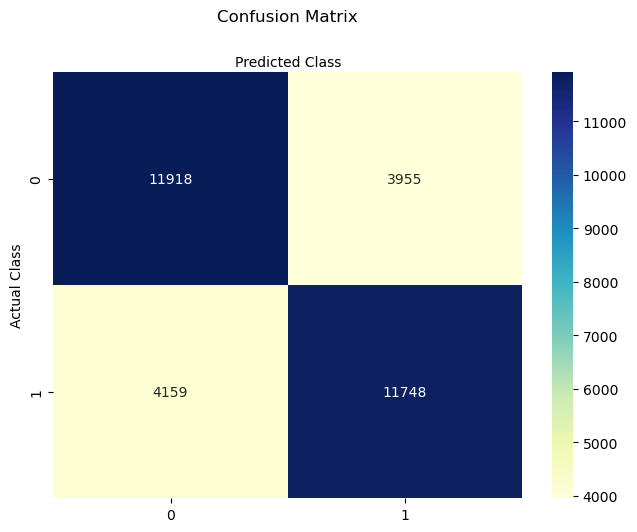

In [74]:
# Print the confusion matrix of the logistic regression model
conf_matrix = metrics.confusion_matrix(Y_test, yhat)
heatmap(conf_matrix)

We can also examine the associated ROC curve as shown below. The shape is almost identical to that of the Linear Regression model.

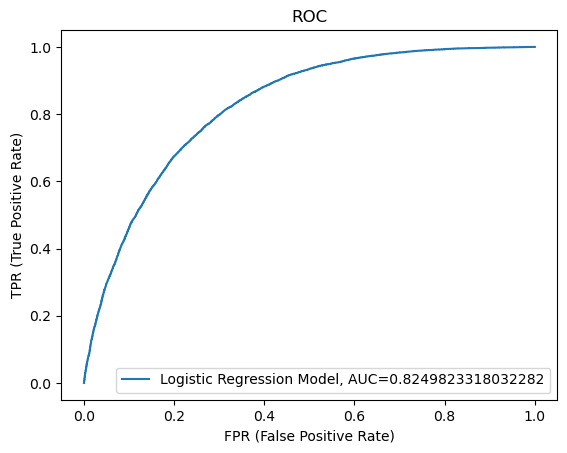

In [75]:
# ROC curve
yhat_p = lr_mod.predict_proba(scaled_test)[::,1]
FPR, TPR, _ = metrics.roc_curve(Y_test,  yhat_p)
AUC = metrics.roc_auc_score(Y_test, yhat_p)
plt.plot(FPR,TPR,label="Logistic Regression Model, AUC="+str(AUC))
plt.legend()
plt.title('ROC')
plt.xlabel('FPR (False Positive Rate)')
plt.ylabel('TPR (True Positive Rate)')
plt.show()

## Results of Logistic Regression:
The results are nearly identical to that of the multilinear model using linear regression. Both have accuracies around 0.75 and have similar ROC curves and AUC values. The next step is to attempt to improve upon the model with cross validation.

Cross validation will split the data into k subsets and train on k-1 of them, while using the k subset as a test set. This approach attempts to limit overfitting risks.

In [76]:
#numpy array conversion
clean_np = clean_df.values

# features/labels
X,Y = clean_np[:,1:20] , clean_np[:,0]

In [77]:
# prep for logistic regression with cross validation
log_cv = sklearn.linear_model.LogisticRegression()

In [78]:
# Create prediction based on cross validation
simplefilter("ignore", category=ConvergenceWarning)
predict = cross_val_predict(log_cv, X, Y, cv=10)

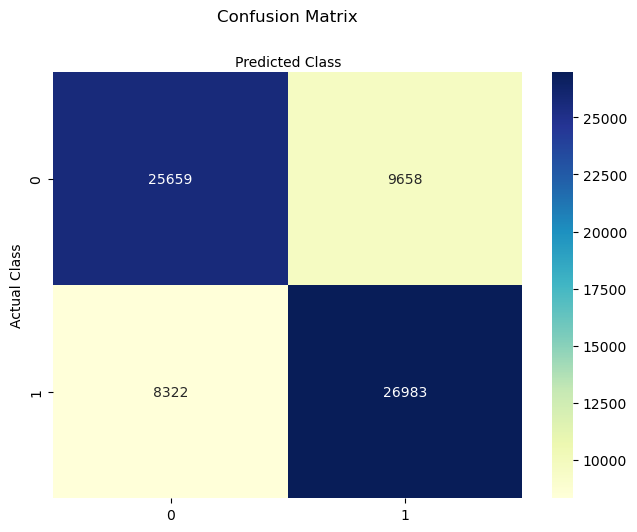

In [79]:
#Generate confusion matrix
conf_matrix_cv = metrics.confusion_matrix(Y, predict)
heatmap(conf_matrix_cv)

In [80]:
#Generate classification report for cross validation
print(classification_report(Y, predict))

              precision    recall  f1-score   support

           0       0.76      0.73      0.74     35317
           1       0.74      0.76      0.75     35305

    accuracy                           0.75     70622
   macro avg       0.75      0.75      0.75     70622
weighted avg       0.75      0.75      0.75     70622



Overall, cross validation did not produce significantly better results than the previous models. However, it did slightly better than the original logistic regression model.

## Removing Collinearity in Logistic Regression
Removing collinearity did not improve results in linear regression but it is something I will try before ruling it out completely.

In [81]:
# Prep for logistic regression model without correlated factors.
lr = sklearn.linear_model.LogisticRegression()
x_train_new = df_train[factors_new].to_numpy()
y_train_new = df_train['Diabetes'].to_numpy()
lr_multilog = lr.fit(x_train_new, y_train_new)  
#Create predictions and compare in classification report:
x_test_new = df_test[factors_new].to_numpy()
y_test_new = df_test['Diabetes'].to_numpy()
yhat_new = lr_multilog.predict(x_test_new)

print(classification_report(y_test_new, yhat_new))

              precision    recall  f1-score   support

           0       0.73      0.74      0.74     15873
           1       0.74      0.72      0.73     15907

    accuracy                           0.73     31780
   macro avg       0.73      0.73      0.73     31780
weighted avg       0.73      0.73      0.73     31780



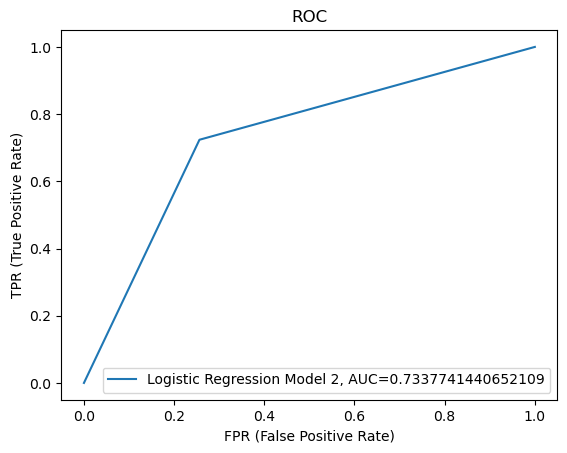

In [82]:
#Create ROC Curve:
FPR, TPR, _ = metrics.roc_curve(y_test_new,  yhat_new)
AUC = metrics.roc_auc_score(y_test_new,  yhat_new)
plt.plot(FPR,TPR,label="Logistic Regression Model 2, AUC="+str(AUC))
plt.legend()
plt.title('ROC')
plt.xlabel('FPR (False Positive Rate)')
plt.ylabel('TPR (True Positive Rate)')
plt.show()

As predicted, this did not make a big difference in model performance. Comparing the accuracy and ROC curves, they are very close.

## Model 3: KNN
KNN involves a nearest neighbor approach which suffers from the curse of dimensionality which implies inaccuracies when involving a large number of dimensions. Therefore, I am expecting an ineffective model due to the high number of dimensions.

First, it is critical to choose an effective k value. The following will run through different k values and assess the accuracy of each.

In [83]:
#The following will look through k values from 1 to 9 and yield the accuracies for each K.
#X_train, X_test, Y_train, Y_test
ks = range(1, 10)
scores = []
for k in ks:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(scaled_train,Y_train)
    yhat = knn.predict(scaled_test)
    scores.append(metrics.accuracy_score(Y_test, yhat))

Text(0, 0.5, 'Accuracy')

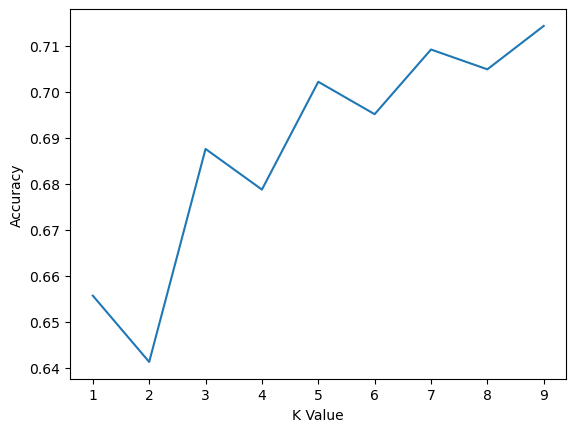

In [84]:
# plotrelationship between K and the testing accuracy 
plt.plot(ks, scores)
plt.xlabel('K Value')
plt.ylabel('Accuracy')

Due to processing power requirements, going above values of k=9 is not feasible although it may be slightly more accurate. There appears to be a horizontal asymptote at around that value too. Therefore, the optimal value with the given data is k = 9. 

In [85]:
#classifier instance with uniform weight of each neighbor.
clsfr = neighbors.KNeighborsClassifier(n_neighbors = 9, weights='uniform')

In [86]:
# fit to training set
clsfr.fit(scaled_train, Y_train)

KNeighborsClassifier(n_neighbors=9)

In [87]:
# create prediction and generate classification report
yhat = clsfr.predict(scaled_test)
print(classification_report(Y_test, yhat, zero_division=0))

              precision    recall  f1-score   support

           0       0.73      0.69      0.71     15873
           1       0.70      0.74      0.72     15907

    accuracy                           0.71     31780
   macro avg       0.71      0.71      0.71     31780
weighted avg       0.71      0.71      0.71     31780



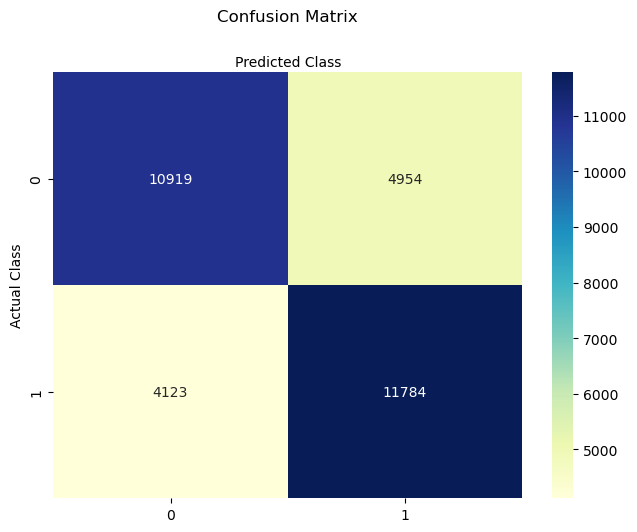

In [88]:
#Print the confusion matrix of the logistic regression model
conf_matrix = metrics.confusion_matrix(Y_test, yhat)
heatmap(conf_matrix)

## KNN Results
As shown above in the confusion matrix and classification report, the data suggests that this model is least effective. However, with additional neighbors and more computational power, it may be feasible for the accuracy to rise. However, this is unlikely as this type of data with this many factors is unlikely to be effective for KNN.

## Discussion/Conclusion 
In conclusion, this project was not what I expected. I initially assumed that there would only be a couple factors that would influence the classification of diabetes or not. However, based on the correlation matrices and relative magnitudes of factors in the Linear Regression models suggested otherwise. I also assumed that the Logistic Regression model would produce much better results than the Linear Regression model but this did not occur. Below are some other concluding thoughts:
* The multilinear model served as a much more accurate model than any of the individual basic models pertaining to Linear Regression. This makes sense as the health field is not always a simple cause and effect relationship and there are several factors that may influence risk of diabetes or other diseases. Accuracy was primarily examined but precision and recall metrics were also displayed and could be emphasized more as it is more costly to falsely determine someone to not have diabetes.
* The Linear Regression and Logistic Regression models were much more effective than the KNN model. This may be attributed to the size of the dataset and the number of factors that influenced classification. KNN is more suited to a smaller dataset and a much smaller number of factors. 
* I expected collinearity to have a bigger influence on model effectiveness. However, because the correlations were not significantly higher than recommended thresholds, removing some redundant factors did not have much of an effect on the results.

### Suggestions for Improvement:
Below, I have listed some suggestions for further analysis and improvement:
* I am curious about Naive Bayes classifier and the effectiveness on using it on this type of dataset.  Because collinearity was not observed to be much of an issue with this dataset, the asusmption of class independence may be sufficient to make use of this type of model. This model would also be effective for a large amount of factors such as with this dataset.
* There may be further opportunities to improve the accuracy of models such as with Linear Regression and Logistic Regression. One such approach is Backward Feature Elimination. This works by including all of the factors in the model, and removing one factor that is least impactful on the effectiveness of the model. This could optimize the model and isolate the most important factors in the dataset.
* Another potential improvement is to investigate additional data with a different set of health indicators. Some of these indicators are prone to biases and do not represent scientific metrics. For example, GenHlth is an arbitrary rating that assesses the overall health of an individual. This is self-reported and some people's perception of what a rating may mean could be different from others. BMI, blood pressure, among other metrics may provide more effective analysis.